[Reference](https://blog.dask.org/2019/03/18/dask-nep18)

The `__array_function__` protocol allows a NumPy function call to dispatch the appropriate NumPy-like library implementation, depending on the array type given as input, thus allowing Dask to remain agnostic of such libraries, internally calling just the NumPy function, which automatically handles dispatching of the appropriate library implementation, for example, CuPy or Sparse.

In [1]:
import numpy as np
import dask.array as da

x = np.random.random((5000, 1000))

d = da.from_array(x, chunks=(1000, 1000))

u, s, v = np.linalg.svd(d)

To speedup SVD computation of a Dask array and offload that work to a CUDA-capable GPU, replace the NumPy array `x` by a CuPy array. Use __array_function__ protocol and dispatch the appropriate CuPy linear algebra operations:

In [2]:
import numpy as np
import cupy
import dask.array as da

x = cupy.random.random((5000, 1000))

d = da.from_array(x, chunks=(1000, 1000))

u, s, v = np.linalg.svd(d)

Start by creating all the arrays that will be used for computing an SVD later.

In [3]:
import numpy as np
import cupy
import dask.array as da

x = np.random.random((10000, 1000))
y = cupy.array(x)

dx = da.from_array(x, chunks=(5000, 1000))
dy = da.from_array(y, chunks=(5000, 1000), asarray=False)

4 arrays:
- `x`: NumPy array in main memory
- `y`: CuPy array in GPU memory
- `dx`: NumPy array wrapped in Dask array
- `dy`: Copy of CuPy array wrapped in Dask array; wrapping a CuPy array in a Dask array as a view (`asarray=True`) not supported yet

# Compute SVD on a NumPy array
Compute SVD of `x` using NumPy. Processed on CPU in a single thread:

In [4]:
%%time

u, s, v = np.linalg.svd(x)

Wall time: 38.5 s


# Compute SVD on the NumPy array wrapped in Dask array
Before introduction of `__array_function__` protocol:

In [7]:
import dask

u, s, v = da.linalg.svd(dx)
u, s, v = dask.compute(u, s, v)

The code above is prohibitive for several projects since one needs to call the proper library dispatcher in addition to passing the correct array. <br>
One would need to find all NumPy calls in the code and replace those by the correct library’s function call, depending on the input array type. 

After `__array_function__`, the same NumPy function can be called using the Dask array `dx` as input:

In [8]:
%%time

u, s, v = np.linalg.svd(dx)
u, s, v = dask.compute(u, s, v)

Wall time: 4.07 s


Dask defers computation of results until its consumption. <br>
Need to call `dask.compute()` function on result arrays to compute them.

Without changing any code besides the wrapping of the NumPy array as a Dask array, a speedup is achieved.

# Compute SVD on the CuPy array
Call NumPy’s SVD function on CuPy array `y`:

In [9]:
%%time

u, s, v = np.linalg.svd(y)

Wall time: 9.08 s


# Compute SVD on the CuPy array wrapped in Dask array
Take advantage of the benefits of **Dask data chunk splitting** and **CuPy GPU implementation** to keep GPU busy as much as possible:

In [10]:
%%time

u, s, v = np.linalg.svd(dy)
u, s, v = dask.compute(u, s, v)

Wall time: 4.66 s


Speedup over single-threaded CuPy SVD computing.

Speedups can be achieved by dispatching the work on a different array.

# Application
Before the `__array_function__` protocol, need to rewrite most of the internal implementation for each and every NumPy-like library to be used as backend. <br>
Need a specialization of the implementation for Dask, another for CuPy and another for Sparse. <br>
With all the functionality that these libraries share through compatible interface, don’t have to change the implementation at all, simply pass a different array type as input.

## Example with scikit-learn

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

N = 1000

# x from 0 to N
x = N * np.random.random((40000, 1))

# y = a*x + b with noise
y = 0.5 * x + 1.0 + np.random.normal(size=x.shape)

# create a linear regression model
est = LinearRegression()

In [12]:
%%time

est.fit(x, y)

Wall time: 23 ms


LinearRegression()

In [13]:
%%time

# predict y from the data
x_new = np.linspace(0, N, 100)
y_new = est.predict(x_new[:, np.newaxis])

Wall time: 0 ns


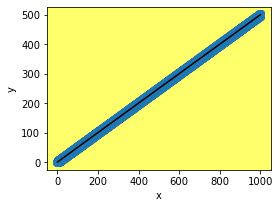

In [14]:
# plot the results
plt.figure(figsize=(4, 3))
ax = plt.axes()
ax.scatter(x, y, linewidth=3)
ax.plot(x_new, y_new, color='black')

ax.set_facecolor((1.0, 1.0, 0.42))

ax.set_xlabel('x')
ax.set_ylabel('y')

ax.axis('tight')

plt.show()

## Example with Dask-GLM
The only thing to change from the code before is the first block:

In [15]:
import numpy as np
from dask_glm.estimators import LinearRegression
import matplotlib.pyplot as plt

N = 1000

# x from 0 to N
x = N * np.random.random((40000, 1))

# y = a*x + b with noise
y = 0.5 * x + 1.0 + np.random.normal(size=x.shape)

# create a linear regression model
est = LinearRegression(solver='lbfgs')

The `lbfgs` solver converges reasonably fast.

In [16]:
%%time

est.fit(x, y)

Wall time: 25.8 ms


C:\Users\user\anaconda3\lib\site-packages\dask\config.py:567: UserWarning: Configuration key "fuse_ave_width" has been deprecated. Please use "optimization.fuse.ave-width" instead
  warnings.warn(


LinearRegression(solver='lbfgs')

In [17]:
%%time

# predict y from the data
x_new = np.linspace(0, N, 100)
y_new = est.predict(x_new[:, np.newaxis])

Wall time: 0 ns


scikit-learn outperforms Dask-GLM using both NumPy and CuPy arrays. <br>
Some likely possibilities:
- scikit-learn may be using solvers that converge faster
- Dask-GLM is entirely built on top of Dask, while scikit-learn may be heavily optimized internally
- Too many synchronization steps and data transfer could occur for small datasets with CuPy